In [1355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [1356]:
# model_path_xLSTM = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240624/SPRA/SPRA_loss_0.3752268239855766_ml_output_SPRA.parquet"

# model_path_s2s = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240801/SPRA/SPRA_loss_0.027396912779659034_ml_output_SPRA.parquet"

model_path_LSTM = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240831/WALT/WALT_loss_2.0569815635681152_ml_output_WALT.parquet"

In [1357]:
# xdf = pd.read_parquet(model_path_xLSTM)
# xdf = xdf.sort_index()

# sdf = pd.read_parquet(model_path_s2s)
# sdf = sdf.sort_index()

ldf = pd.read_parquet(model_path_LSTM)
# ldf['Model forecast'] = (ldf['Model forecast']*4.0)
ldf["diff"] = ldf.iloc[:, 0] - ldf.iloc[:, 1]
ldf = ldf.sort_index()

In [1358]:
full_df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240901/WALT/09_01_2024_00:03:12_full_WALT.parquet"
)

In [1359]:
for k in full_df.keys():
    print(k)

valid_time
valid_time_cos
valid_time_sin
u_total_WALT_+3
u_total_WALT_+6
t2m_WALT
target_error
sh2_WALT
d2m_WALT
r2_WALT
u10_WALT
v10_WALT
u_total_WALT
u_dir_WALT
tp_WALT
prmsl_WALT
orog_WALT
tcc_WALT
cape_WALT
cin_WALT
dswrf_WALT
dlwrf_WALT
gh_WALT
lulc_cat_WALT
elev_cat_WALT
slope_cat_WALT
t2m_DEPO
sh2_DEPO
d2m_DEPO
r2_DEPO
u10_DEPO
v10_DEPO
u_total_DEPO
u_dir_DEPO
tp_DEPO
prmsl_DEPO
orog_DEPO
tcc_DEPO
cape_DEPO
cin_DEPO
dswrf_DEPO
dlwrf_DEPO
gh_DEPO
lulc_cat_DEPO
elev_cat_DEPO
slope_cat_DEPO
t2m_ANDE
sh2_ANDE
d2m_ANDE
r2_ANDE
u10_ANDE
v10_ANDE
u_total_ANDE
u_dir_ANDE
tp_ANDE
prmsl_ANDE
orog_ANDE
tcc_ANDE
cape_ANDE
cin_ANDE
dswrf_ANDE
dlwrf_ANDE
gh_ANDE
lulc_cat_ANDE
elev_cat_ANDE
slope_cat_ANDE
t2m_LAUR
sh2_LAUR
d2m_LAUR
r2_LAUR
u10_LAUR
v10_LAUR
u_total_LAUR
u_dir_LAUR
tp_LAUR
prmsl_LAUR
orog_LAUR
tcc_LAUR
cape_LAUR
cin_LAUR
dswrf_LAUR
dlwrf_LAUR
gh_LAUR
lulc_cat_LAUR
elev_cat_LAUR
slope_cat_LAUR
lat_WALT
lon_WALT
elev_WALT
tair_WALT
ta9m_WALT
td_WALT
relh_WALT
srad_WALT
pres_WALT


In [1360]:
ldf["valid_time"] = full_df["valid_time"]
# sdf["valid_time"] = full_df["valid_time"]
# xdf["valid_time"] = full_df["valid_time"]
# df['rnn_err'] = rnn_df['diff']

In [1361]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            f = int(len(df_test) * 0.5)
            df_val = df_test.iloc[-f:]
            df_test = df_test[:f]

    return df_train["valid_time"], df_test["valid_time"], df_val["valid_time"]

In [1362]:
station = "ESSX"

In [1363]:
ldf["valid_time"] = pd.to_datetime(ldf["valid_time"])

In [1364]:
# ldf.dropna(inplace=True)

In [1365]:
ldf

,target_error_lead_0,Model forecast,diff,valid_time
0,-0.235132,-0.697828,0.462697,2018-01-01 12:00:00
1,-1.352194,-1.060416,-0.291778,2018-01-01 18:00:00
2,-0.553759,-1.178047,0.624288,2018-01-02 00:00:00
3,-1.308226,-0.986384,-0.321842,2018-01-02 06:00:00
4,-1.370371,-1.214905,-0.155466,2018-01-02 12:00:00
...,...,...,...,...
2206,-0.290805,-0.328750,0.037945,2019-08-30 18:00:00
2207,1.207197,-0.095685,1.302883,2019-08-31 00:00:00
2208,-1.235555,-0.134882,-1.100673,2019-08-31 06:00:00
2209,0.708954,-0.284992,0.993947,2019-08-31 12:00:00


In [1366]:
df_train, df_test, df_val = which_fold(ldf, 4)

In [1367]:
df_val

1990   2019-07-07 00:00:00
1991   2019-07-07 06:00:00
1992   2019-07-07 12:00:00
1993   2019-07-07 18:00:00
1994   2019-07-08 00:00:00
               ...        
2206   2019-08-30 18:00:00
2207   2019-08-31 00:00:00
2208   2019-08-31 06:00:00
2209   2019-08-31 12:00:00
2210   2019-08-31 18:00:00
Name: valid_time, Length: 221, dtype: datetime64[ns]

In [1368]:
test_set_start = df_val.iloc[0]
test_set_start

Timestamp('2019-07-07 00:00:00')

In [1369]:
test_set_finish = df_val.iloc[-1]
test_set_finish

Timestamp('2019-08-31 18:00:00')

In [1370]:
df_test.iloc[0]

Timestamp('2019-05-07 06:00:00')

In [1371]:
df_test.iloc[-1]

Timestamp('2019-07-06 12:00:00')

In [1372]:
def date_filter(ldf, time1, time2):
    ldf = ldf[ldf["valid_time"] > time1]
    ldf = ldf[ldf["valid_time"] < time2]

    return ldf

## Time filter 

In [1373]:
# time1 = datetime(2023, 5, 16, 0, 0, 0)
# time2 = datetime(2023, 12, 31, 23, 0, 0)

# ldf = date_filter(ldf, time1, time2)
# # xdf = date_filter(xdf, time1, time2)
# # sdf = date_filter(sdf, time1, time2)
# full_df = date_filter(full_df, time1, time2)

In [1374]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def create_heatmap(df, x_column="target_error_lead_0", y_column="Model forecast"):
    # Round values
    df[x_column] = np.round(df[x_column] / 1.0) * 1.0
    df[y_column] = np.round(df[y_column] / 1.0) * 1.0

    # Pivot the DataFrame to create a matrix suitable for the heatmap
    heatmap_data = pd.pivot_table(
        df, index=y_column, columns=x_column, aggfunc="size", fill_value=0
    )

    # Calculate percentages
    total = heatmap_data.sum()
    heatmap_data_percent = (heatmap_data / total) * 100

    # Create the heatmap using seaborn
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        heatmap_data_percent,
        vmax=100,
        cmap="Reds",
        annot=True,
        fmt=".1f",  # Format as percentage with one decimal place
        cbar_kws={"label": "Percentage (%)"},  # Add color bar label
    )

    # Set the labels and title
    plt.xlabel("Target")
    plt.ylabel("LSTM")
    plt.title("Heatmap of Target vs LSTM")

    # Show the heatmap
    plt.show()

In [1375]:
def quantile_regression(x, y):
    X = x[:, np.newaxis]
    quantiles = [0.10, 0.5, 0.90]
    predictions = {}
    out_bounds_predictions = np.zeros_like(y, dtype=np.bool_)
    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred

    predictions_df = pd.DataFrame()
    predictions_df["target"] = x

    for q in quantiles:
        predictions_df[q] = predictions.get(q)

    return qr, y_pred, predictions_df

In [1376]:
# from sklearn.utils.fixes import parse_version, sp_version
# from sklearn.linear_model import QuantileRegressor
# import matplotlib.pyplot as plt
# import statistics as st

# # This is line is to avoid incompatibility if older SciPy version.
# # You should use `solver="highs"` with recent version of SciPy.
# solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"


# x = ldf['Model forecast'].values
# y = ldf['diff'].values

# qr, y_pred, predictions_df = quantile_regression(x, y)

In [1377]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def ml_output(df, full_df, fold, station, test_set_start, test_set_finish):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df["target_error_lead_0"]),
        c="black",
        linewidth=1,
        label="Target",
    )

    plt.plot(
        np.array(x),
        np.array(df["Model forecast"]),
        c="r",
        linewidth=3,
        alpha=0.7,
        label="LSTM Output",
    )

    # plt.axvline(
    #     x=test_set_start,
    #     c="green",
    #     linestyle="--",
    #     linewidth=2.0,
    #     label="Test Set Start",
    # )
    # plt.axvline(
    #     x=test_set_finish,
    #     c="red",
    #     linestyle="--",
    #     linewidth=2.0,
    #     label="Test Set Finish",
    # )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric, -4, 4.1, where=day_mask, color="white", alpha=0.5, label="Daytime"
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric, -4, 4.1, where=~day_mask, color="grey", alpha=0.2, label="Nighttime"
    )

    ax.set_title(f"LSTM Output v Target: {station}: FH06", fontsize=28)
    # plt.ylim(-5, 5.)
    ax.legend()

    plt.show()


# Example usage
# ml_output(df, fold, station)

In [1378]:
ldf

,target_error_lead_0,Model forecast,diff,valid_time
0,-0.235132,-0.697828,0.462697,2018-01-01 12:00:00
1,-1.352194,-1.060416,-0.291778,2018-01-01 18:00:00
2,-0.553759,-1.178047,0.624288,2018-01-02 00:00:00
3,-1.308226,-0.986384,-0.321842,2018-01-02 06:00:00
4,-1.370371,-1.214905,-0.155466,2018-01-02 12:00:00
...,...,...,...,...
2206,-0.290805,-0.328750,0.037945,2019-08-30 18:00:00
2207,1.207197,-0.095685,1.302883,2019-08-31 00:00:00
2208,-1.235555,-0.134882,-1.100673,2019-08-31 06:00:00
2209,0.708954,-0.284992,0.993947,2019-08-31 12:00:00


In [1379]:
mean = st.mean(abs(ldf["diff"]))
mean

0.5825202922511652

In [1380]:
mean_s = st.mean(ldf["diff"] ** 2)
mean_s

0.5646739294348315

In [1381]:
avg = 12

In [1382]:
# predictions_df.head()

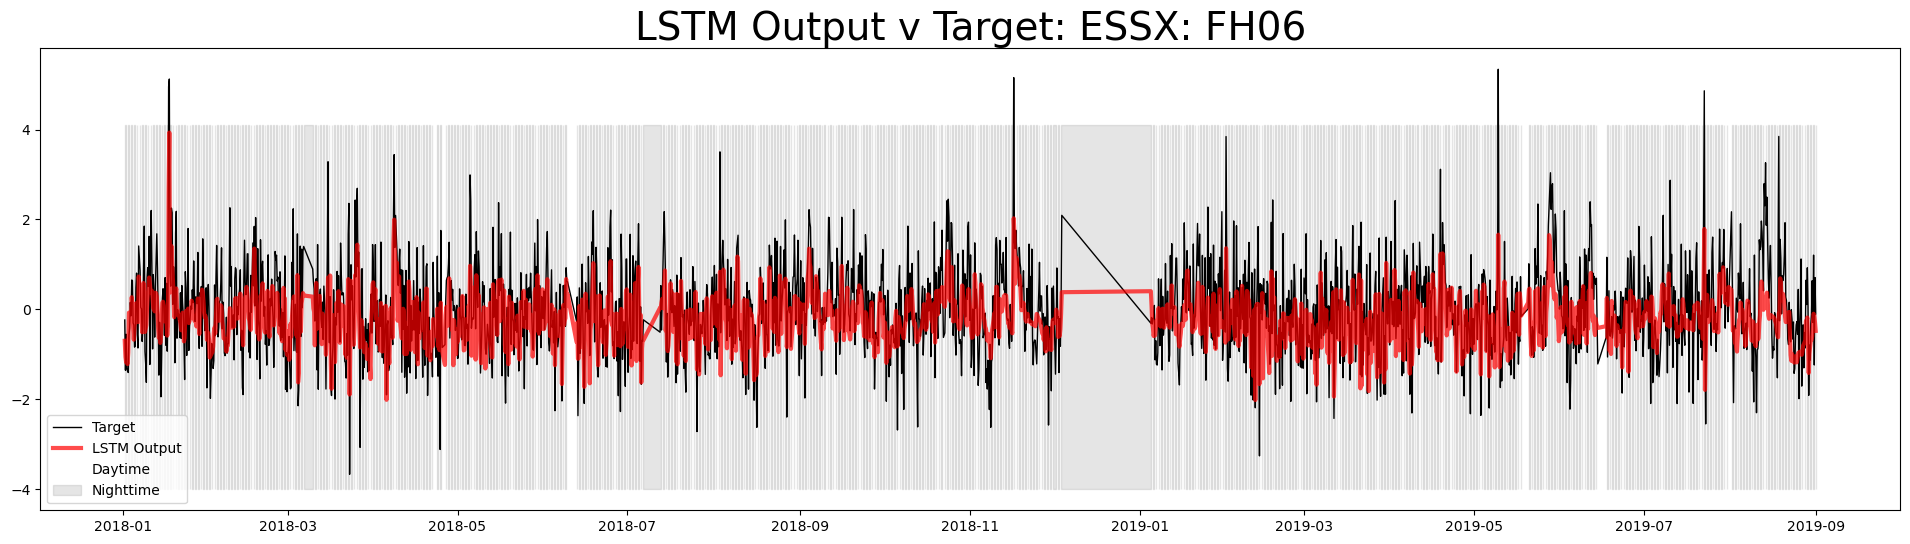

In [1383]:
x = ml_output(ldf, full_df, 4, station, test_set_start, test_set_finish)

In [1384]:
ldf.head()

,target_error_lead_0,Model forecast,diff,valid_time
0,-0.235132,-0.697828,0.462697,2018-01-01 12:00:00
1,-1.352194,-1.060416,-0.291778,2018-01-01 18:00:00
2,-0.553759,-1.178047,0.624288,2018-01-02 00:00:00
3,-1.308226,-0.986384,-0.321842,2018-01-02 06:00:00
4,-1.370371,-1.214905,-0.155466,2018-01-02 12:00:00


In [1385]:
full_df["Abs_err"] = ldf["diff"]

In [1386]:
for k in full_df.columns:
    if re.search(
        f"{station}|valid|Model forecast|Abs_err",
        k,
    ):
        continue
    else:
        full_df = full_df.drop(columns=[k])

In [1387]:
# test_len = int(len(full_df['valid_time'])*0.2)
# full_df = full_df.iloc[0:test_len]

In [1388]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month), (df.valid_time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(1, len(the_list) + 1)
    plt.bar(x, the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])
    ax.set_xticks(np.arange(1, len(the_list) + 1, int((len(the_list) + 1) / 6)))
    return the_list

In [1389]:
full_df.head()

,valid_time,valid_time_cos,valid_time_sin,Abs_err
0,2018-01-01 12:00:00,0.999853,0.017166,0.462697
1,2018-01-01 18:00:00,0.999853,0.017166,-0.291778
2,2018-01-02 00:00:00,0.999411,0.034328,0.624288
3,2018-01-02 06:00:00,0.999411,0.034328,-0.321842
4,2018-01-02 12:00:00,0.999411,0.034328,-0.155466


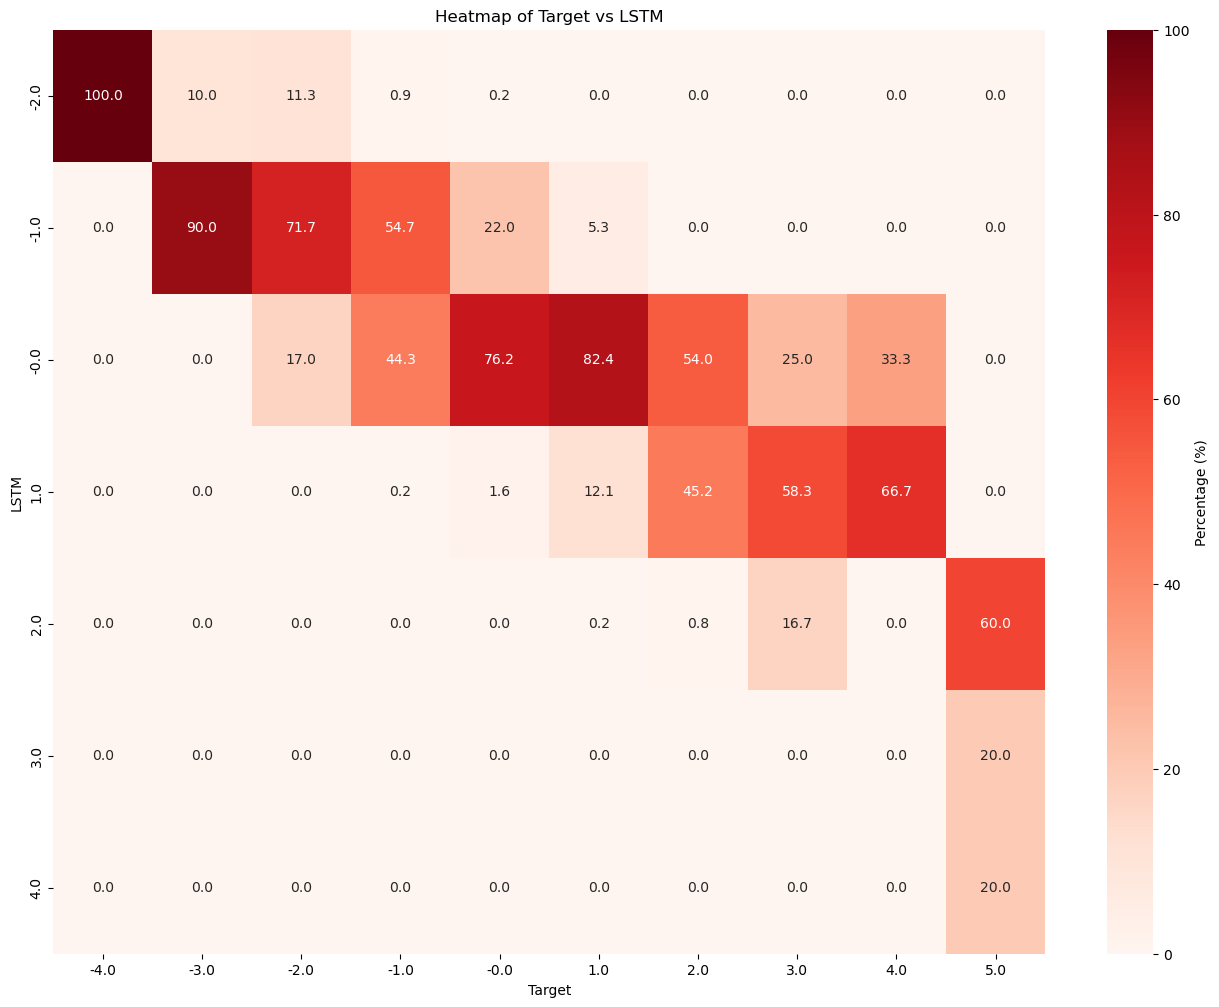

In [1390]:
create_heatmap(ldf)

/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/2351311710.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])


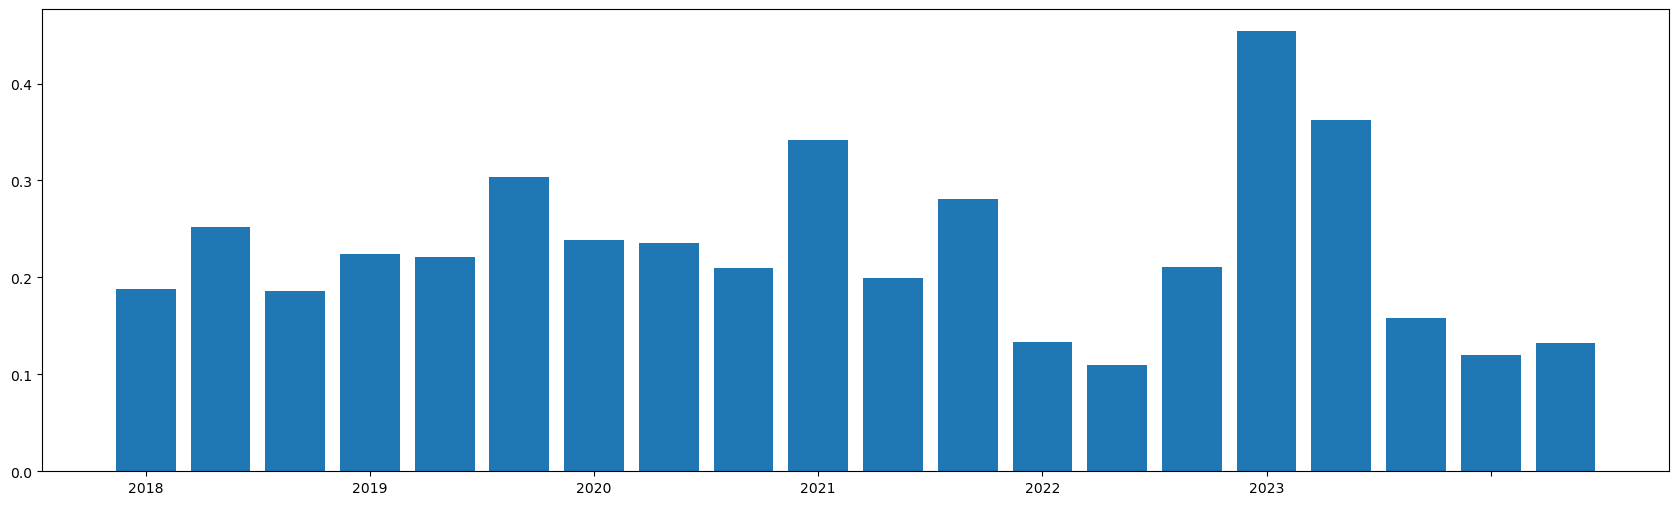

In [1391]:
err_by_month = groupby_month(full_df, "Abs_err")

In [1392]:
def groupby_time(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.hour)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))
    plt.bar(x, the_list, color="g")
    return the_list

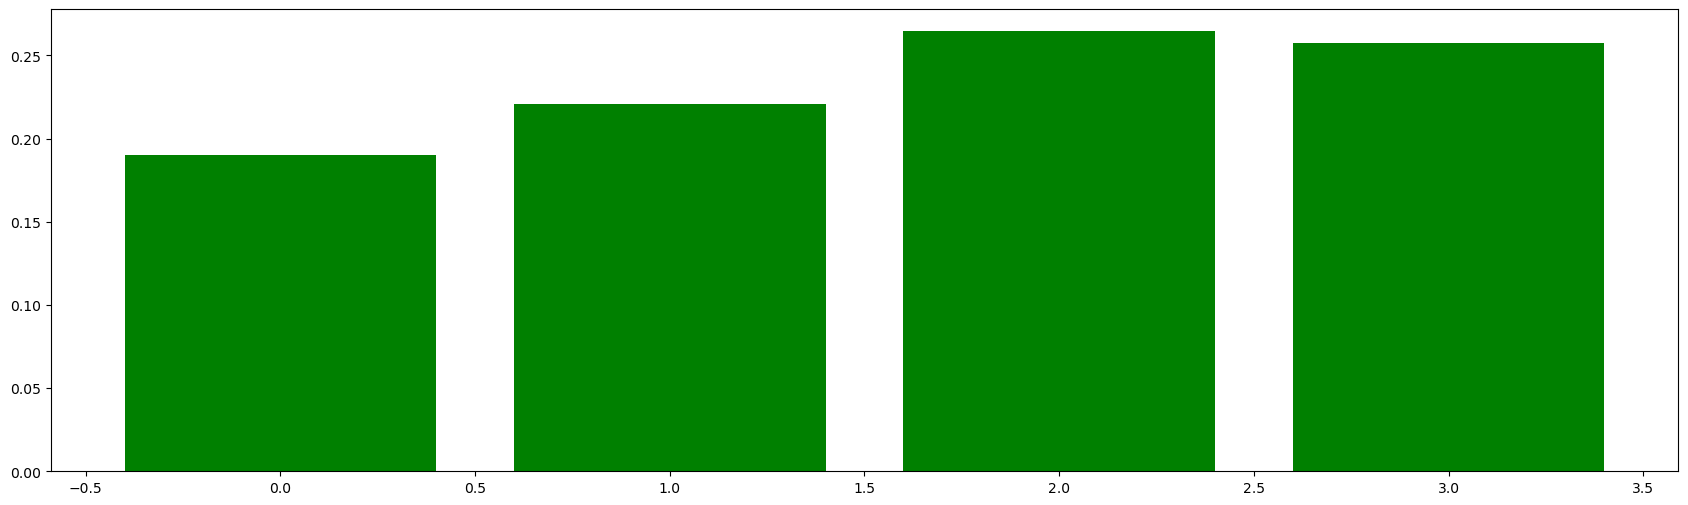

In [1393]:
err_by_time = groupby_time(full_df, "Abs_err")

In [1394]:
import calendar


def groupby_month_total(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))

    # Get a colormap
    cmap = plt.get_cmap("RdBu")
    # Normalize your data to map to the colormap
    norm = plt.Normalize(min(the_list), max(the_list))
    colors = cmap(norm(the_list))

    # Create a bar chart
    plt.bar(x, the_list, color=colors)
    ax.set_xticks(x)  # Set x-ticks to be at the positions of the months
    month_labels = [calendar.month_name[month] for month in GB.index]
    ax.set_xticklabels(month_labels)  # Label x-ticks with month numbers

    plt.show()
    return the_list

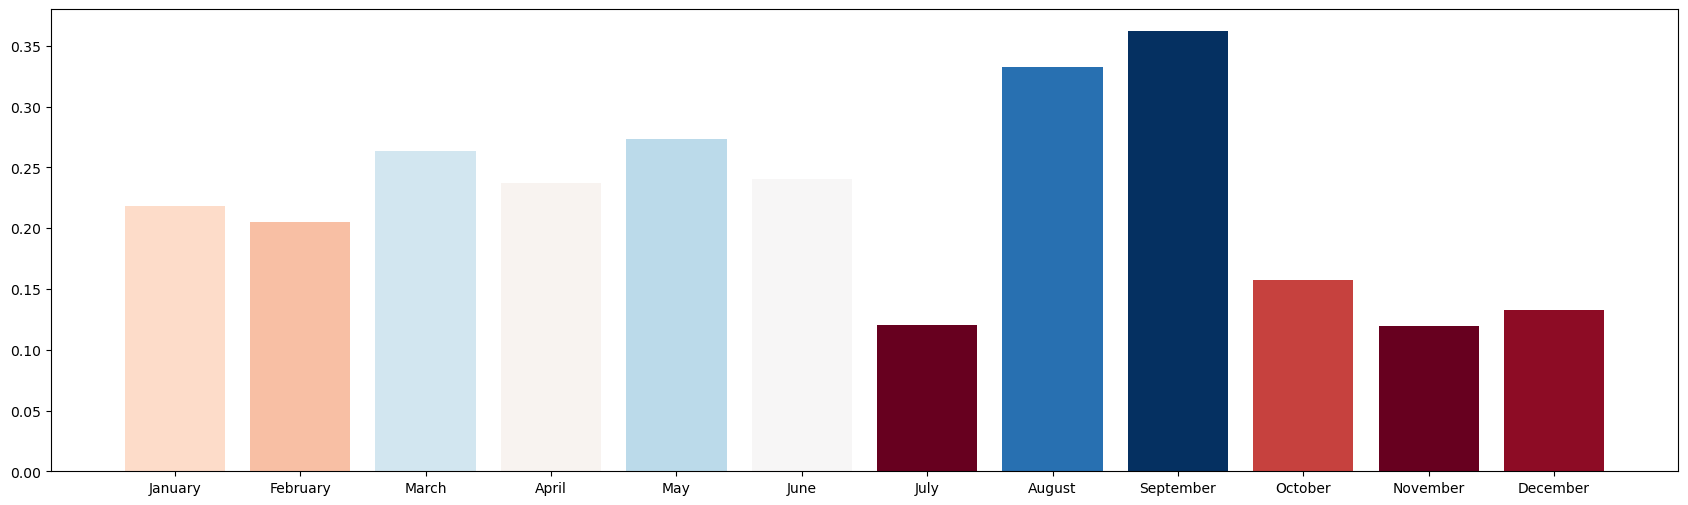

[0.21809444138123965,
 0.2048949723319922,
 0.2638939045991802,
 0.2371913915832706,
 0.27337053098097347,
 0.24038837257160076,
 0.12032013086640007,
 0.33232115944529994,
 0.36201023214114114,
 0.15778210366738757,
 0.11974959748490285,
 0.1327917426842001]

In [1395]:
groupby_month_total(full_df, "Abs_err")

In [1396]:
def myround(x, base):
    return base * round(x / base)

In [1397]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [1398]:
def err_bucket(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))

    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        err = full_df["Abs_err"].iloc[i]
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]

    return temp_df, instances

In [1399]:
def plot_buckets(temp_df, instances, var_name, cmap, width):
    my_cmap = plt.get_cmap(cmap)
    averages = temp_df / instances
    y = averages
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    the_list = averages.tolist()
    fig, ax = plt.subplots(
        figsize=(21, 6), facecolor="slategrey", constrained_layout=True
    )
    bars = plt.bar(temp_df.keys(), the_list, color=my_cmap(rescale(y)), width=width)
    ax.set_title("Absolute Error of LSTM", fontsize=28, c="white")
    ax.set_xlabel(var_name, fontsize=18, c="white")
    ax.set_ylabel("Mean Absolute Error", fontsize=18, c="white")
    # Iterating over the bars one-by-one
    # Annotate each bar with its value
    # Annotate each bar with the number of instances
    for bar, value, instance_count in zip(bars, the_list, instances):
        yval = value + 0.01  # Adjust the vertical position of the label
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"n={instance_count}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
        )

In [1400]:
# for k in full_df.keys():
#     print(k)

In [1401]:
# diector = sorted(os.listdir('/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/'))

# for d in diector:
#         full_df = pd.read_parquet(
#         f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/{d}"
#     )
#         for k in full_df.columns:
#             if re.search(
#                 f"{station}",
#                 k,
#             ):
#                 print("Succes!!")
#                 print(d)
#             else:
#                 continue

In [1402]:
full_df

,valid_time,valid_time_cos,valid_time_sin,Abs_err
0,2018-01-01 12:00:00,0.999853,0.017166,0.462697
1,2018-01-01 18:00:00,0.999853,0.017166,-0.291778
2,2018-01-02 00:00:00,0.999411,0.034328,0.624288
3,2018-01-02 06:00:00,0.999411,0.034328,-0.321842
4,2018-01-02 12:00:00,0.999411,0.034328,-0.155466
...,...,...,...,...
7438,2023-12-30 18:00:00,0.999411,-0.034328,NaN
7439,2023-12-31 00:00:00,0.999853,-0.017166,NaN
7440,2023-12-31 06:00:00,0.999853,-0.017166,NaN
7441,2023-12-31 12:00:00,0.999853,-0.017166,NaN


In [1403]:
temp_df, instances = err_bucket(full_df, f"tair_{station}", 2)

KeyError: 'tair_ESSX'

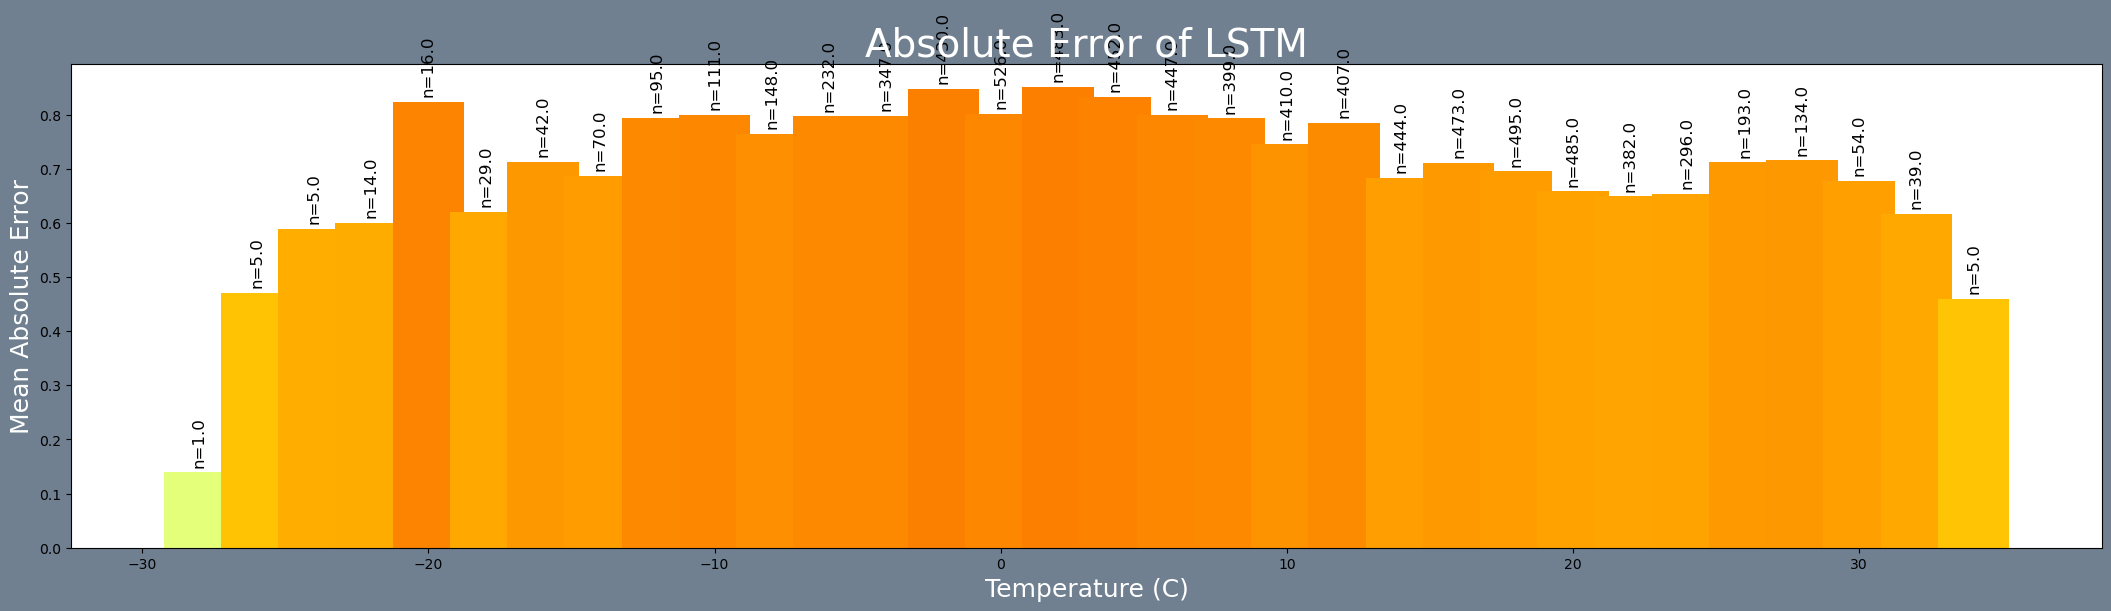

In [ ]:
plot_buckets(temp_df, instances, "Temperature (C)", "Wistia", 2.5)

In [ ]:
relh_df, instances = err_bucket(full_df, f"relh_{station}", 2)

/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:20: FutureWarning: 

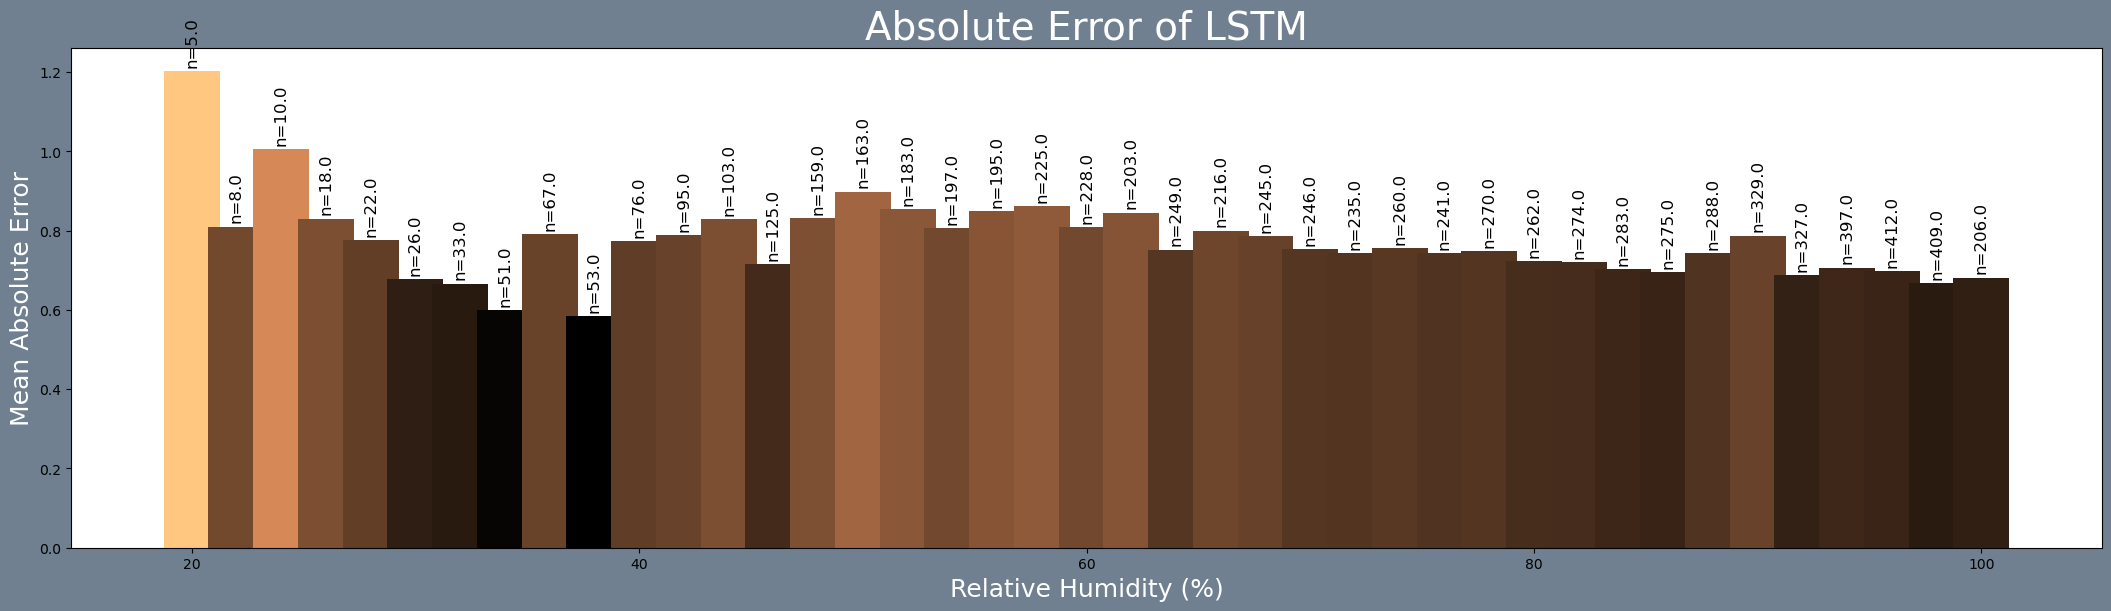

In [ ]:
plot_buckets(relh_df, instances, "Relative Humidity (%)", "copper", 2.5)

In [ ]:
new_df, instances = err_bucket(full_df, f"srad_{station}", 40)

/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:20: FutureWarning: 

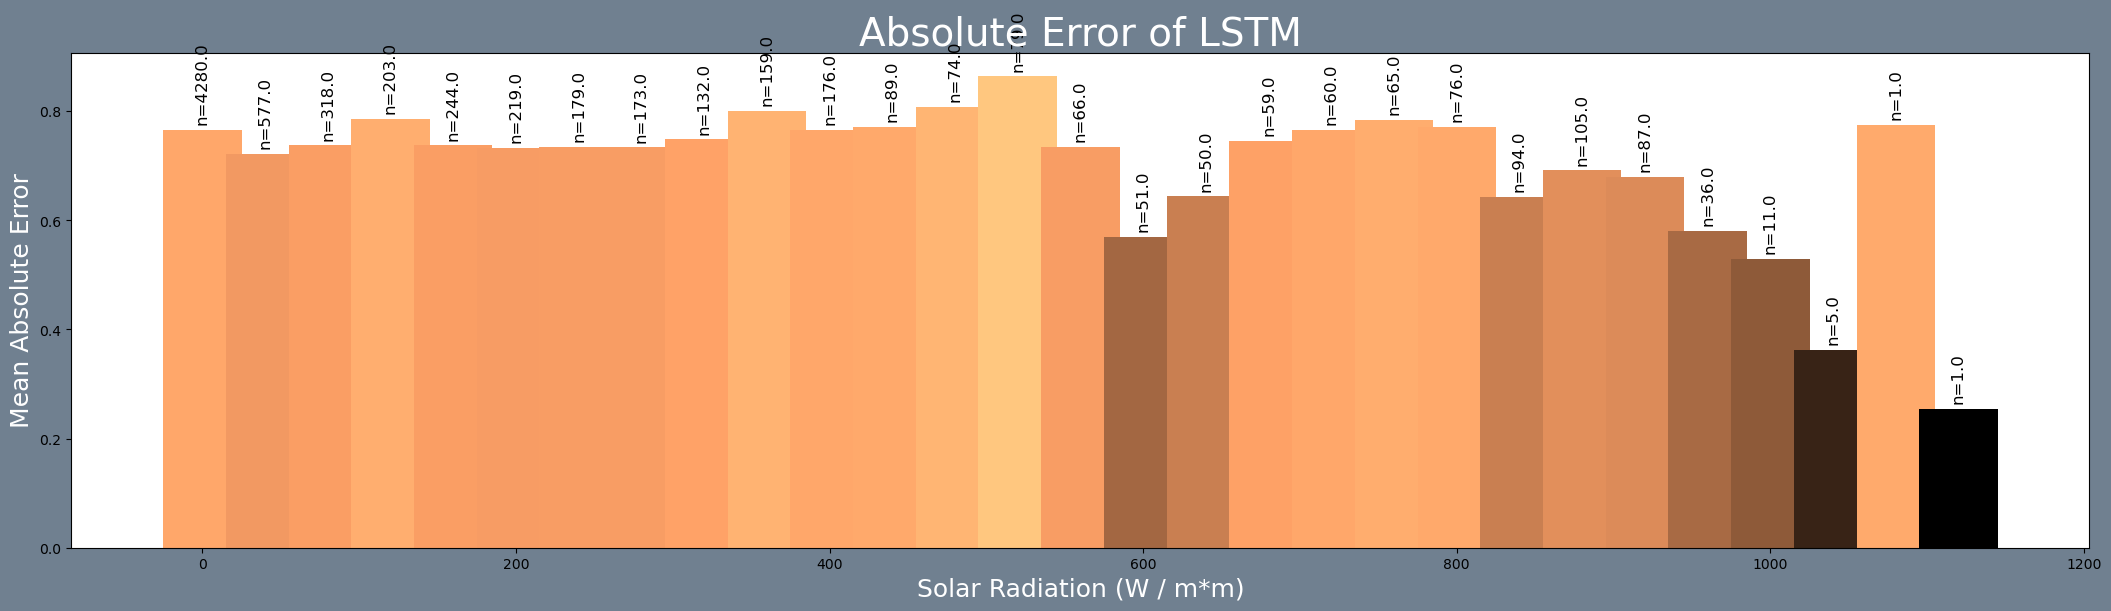

In [ ]:
plot_buckets(new_df, instances, "Solar Radiation (W / m*m)", "copper", 50.0)

In [ ]:
pres_df, instances = err_bucket(full_df, f"pres_{station}", 2)

/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:20: FutureWarning: 

In [ ]:
print(f'The mean pressure at {station} is {full_df[f"pres_{station}"].mean()}')

The mean pressure at ESSX is 1009.373046875


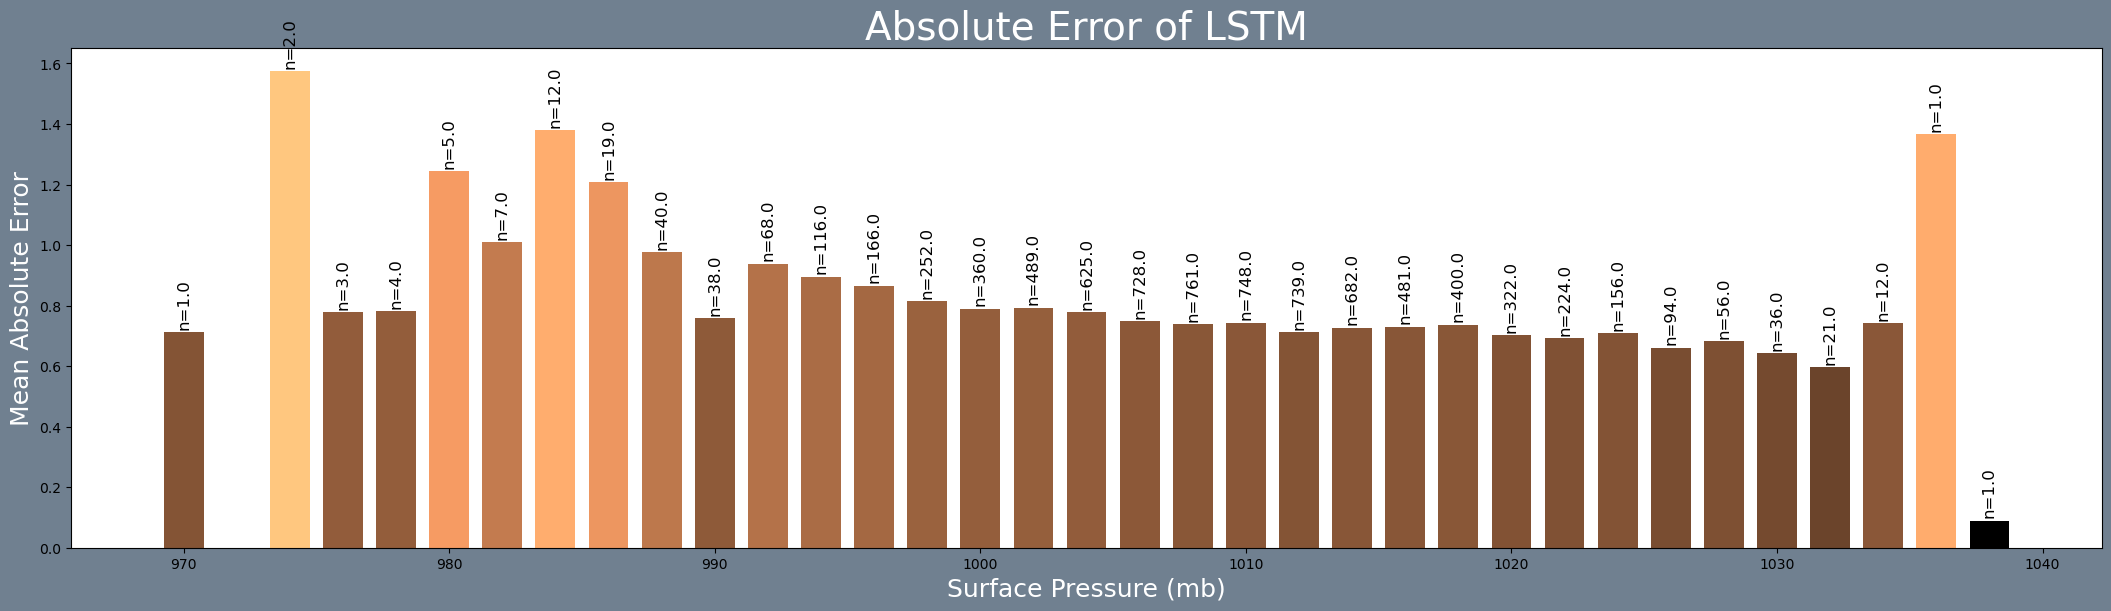

In [ ]:
plot_buckets(pres_df, instances, "Surface Pressure (mb)", "copper", 1.5)

In [ ]:
def round_small(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
            temps.append(rounded)
        else:
            rounded = myround(full_df[met_col].iloc[i], 1)
            temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))
    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
        else:
            rounded = float(myround(full_df[met_col].iloc[i], base=1))
        err = float(full_df["Abs_err"].iloc[i])
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]
    temp_df = temp_df.loc[~(temp_df == 0)]
    instances = instances.loc[~(instances == 0)]
    return temp_df, instances

In [ ]:
rain_df, instances = err_bucket(full_df, f"precip_total_{station}", 2)

/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:20: FutureWarning: 

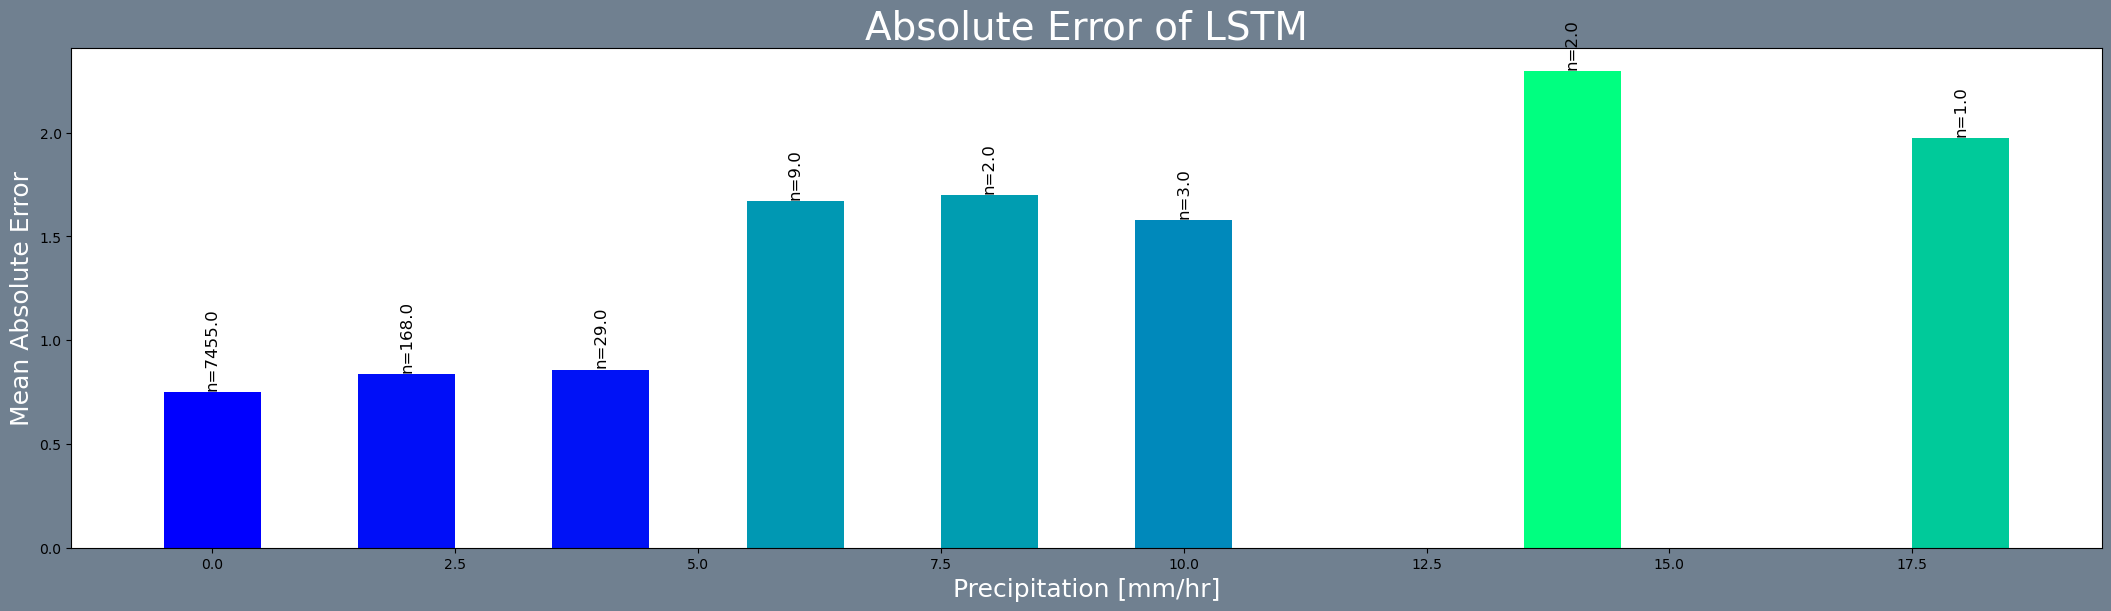

In [ ]:
plot_buckets(rain_df, instances, "Precipitation [mm/hr]", "winter", 1.0)

In [ ]:
snow_df, instances = round_small(full_df, f"snow_depth_{station}", 2)

/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1323447786.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1323447786.py:26: FutureWarning: 

In [ ]:
snow_df = snow_df.iloc[1:]
instances = instances.iloc[1:]

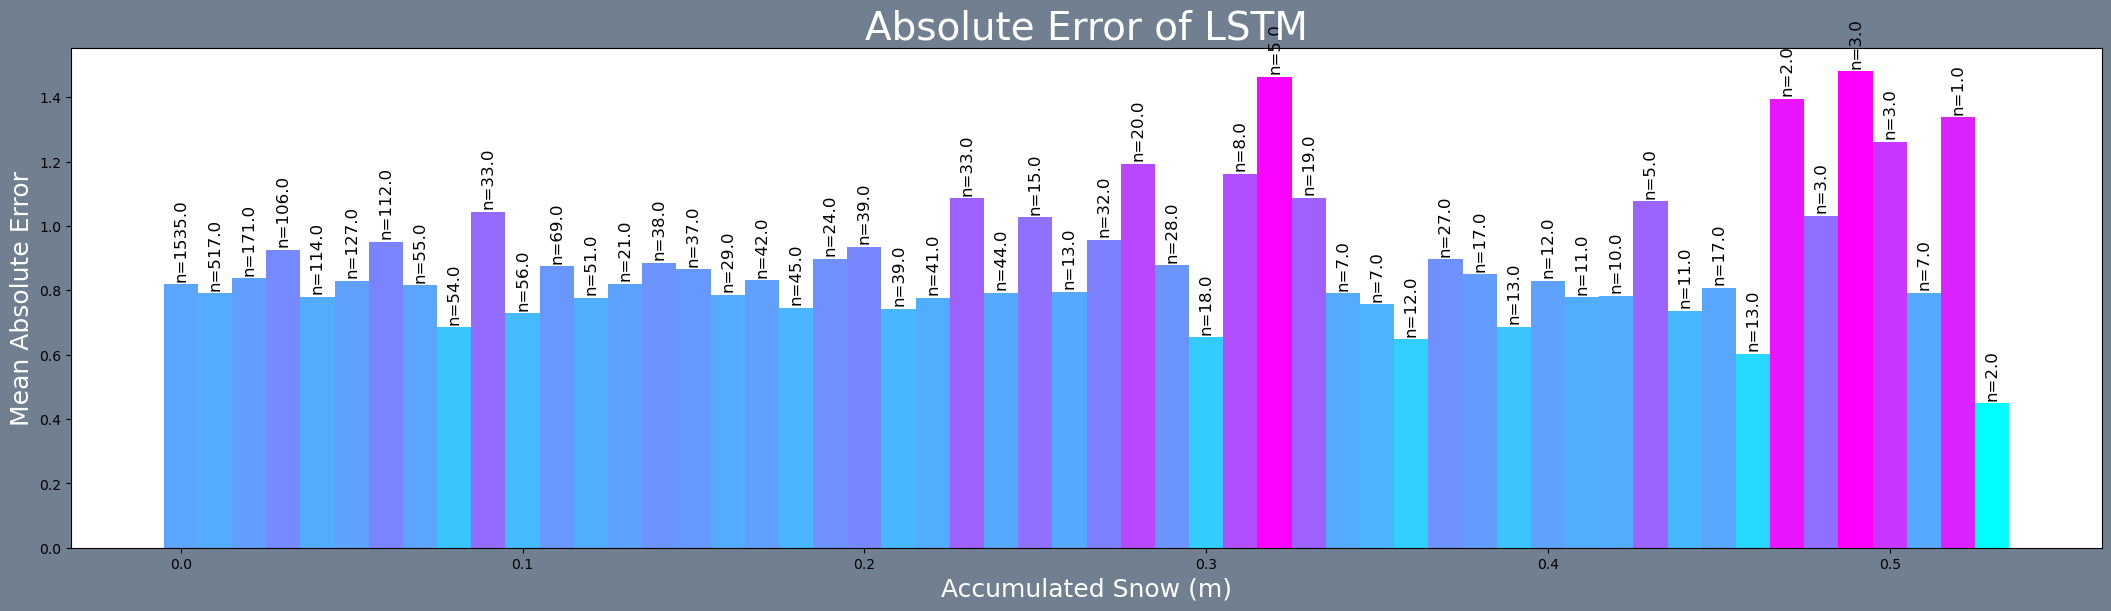

In [ ]:
plot_buckets(snow_df, instances, "Accumulated Snow (m)", "cool", 0.01)

In [ ]:
wmax, instances = err_bucket(full_df, f"wmax_sonic_{station}", 2)

/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:20: FutureWarning: 

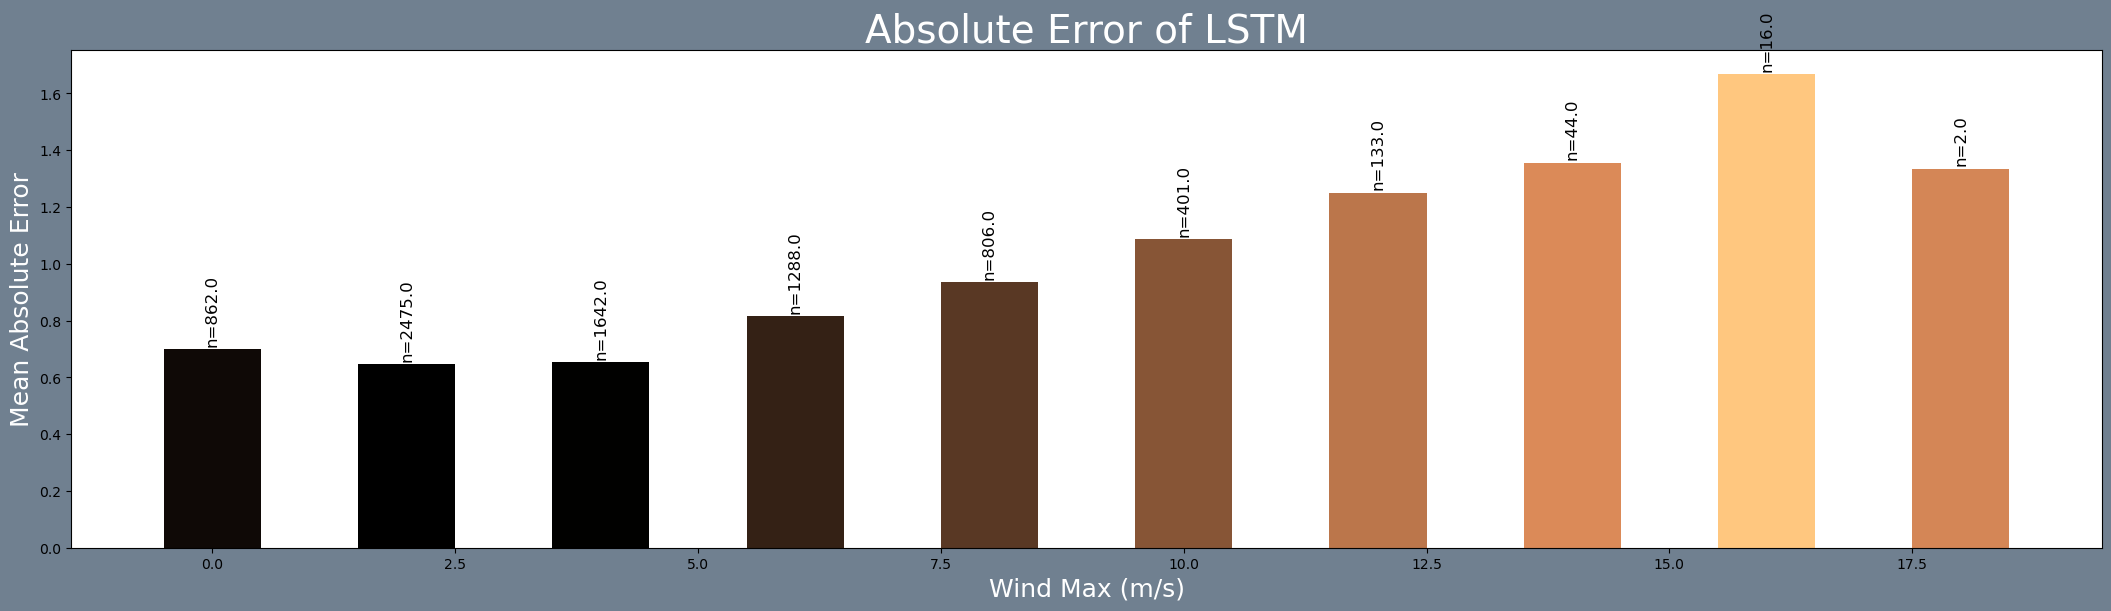

In [ ]:
plot_buckets(wmax, instances, "Wind Max (m/s)", "copper", 1.0)

In [ ]:
wdir, instances = err_bucket(full_df, f"wdir_sonic_{station}", 45)

/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.gtlBbaeiB2/ipykernel_2351095/1558746766.py:20: FutureWarning: 

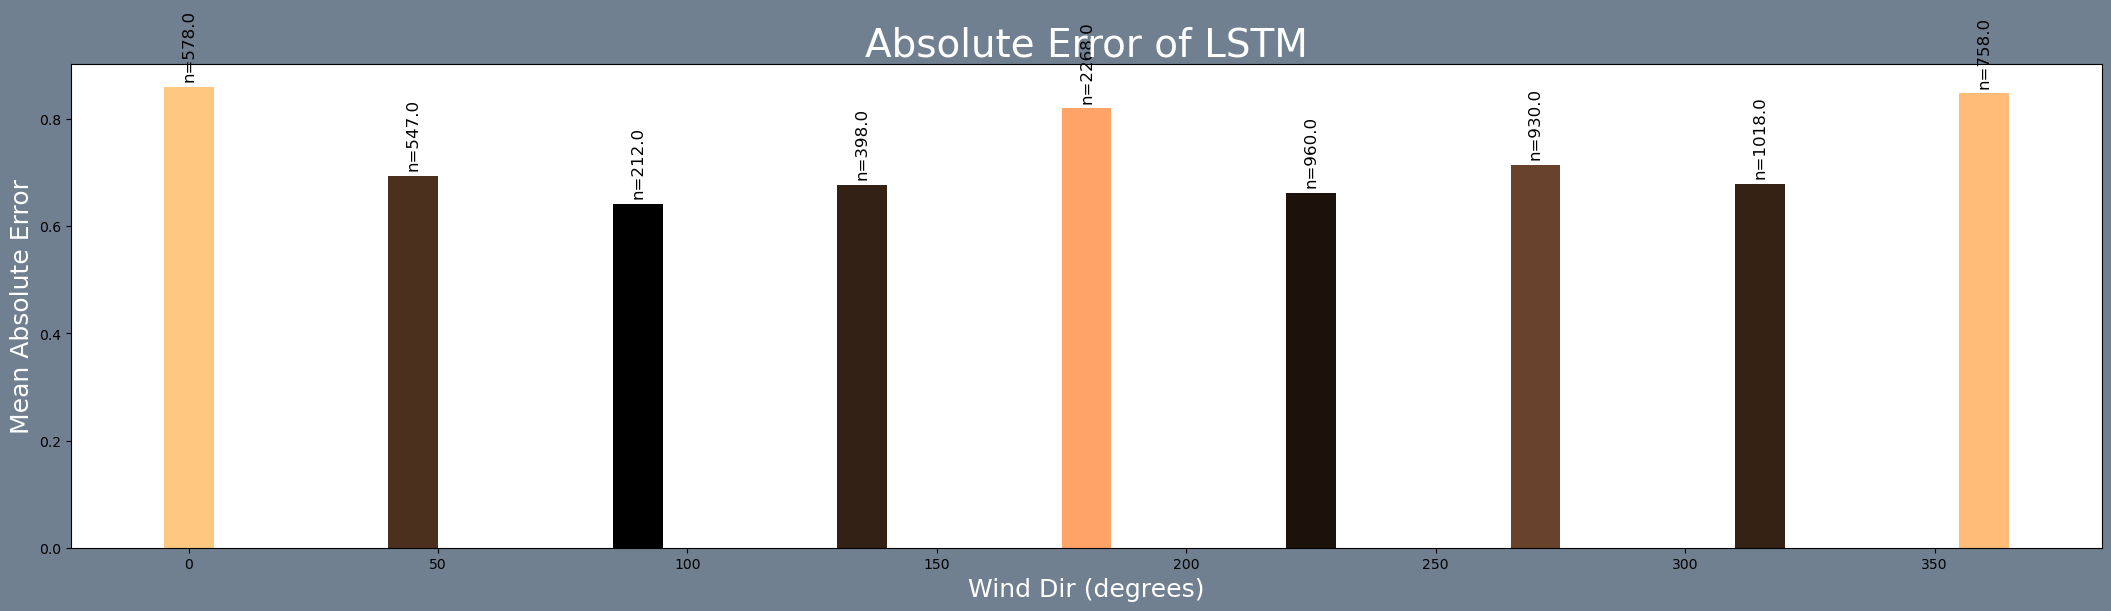

In [ ]:
plot_buckets(wdir, instances, "Wind Dir (degrees)", "copper", 10.0)